<a href="https://colab.research.google.com/github/ggesa432/ggesa432/blob/master/LDRPM_Loan_Default_Risk_Prediction_Model_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'home-credit-credit-risk-model-stability:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F50160%2F7921029%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240501%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240501T201144Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D09c76022cf0d0de93adb88b8bf750fc78ff49f606af210810ac4bd8255345c72ef4cadf1e0f70adda5796e442b366f9a51e4b97584d36b68ed7a11af33fc7f8f1fea7b10ca6741fbe40479351ffc6ae10bd7e93ecda6a029b4b5453c0a01eb32870686a3d2145eac5735d87cfbbca95d481bb823dacae49e09e7cd3d7c4e83be28f1ba15d3fb212499dd16e3ff9ab1e6748f92d2fec5b17a158f52c087a1ecd963b73917a2ecb29bdabbc4c2bc0d58db905853ab20ba33fabbcf614c437bcdda6da9e11a1661cfd176cc967348bfe4de5e1de692775a0e2707a5dff945ad37c32953a89ccd30c349172bba6e9daea046fbb444a23a96ac3848c4f1d81938b121'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3375704785 bytes downloaded
Downloaded and uncompressed: home-credit-credit-risk-model-stability
Data source import complete.


In [ ]:
!pip install catboost


In [ ]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import GroupKFold

import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError


### Pre-Fitted Voting Model

In [ ]:
class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

### Pipeline

In [ ]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.Utf8))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))

        return df

    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))

        df = df.drop("date_decision", "MONTH")

        return df

    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.Utf8):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

### Automatic Aggregation

In [ ]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

### File I/O

In [ ]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)

    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))

    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)

        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))

        chunks.append(df)

    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])

    return df

### Feature Engineering

In [ ]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )

    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")

    df_base = df_base.pipe(Pipeline.handle_dates)

    return df_base

In [ ]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()

    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)

    df_data[cat_cols] = df_data[cat_cols].astype("category")

    return df_data, cat_cols

### Configuration

In [ ]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

### Train Files Read & Feature Engineering

In [ ]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [ ]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 472)


### Test Files Read & Feature Engineering

In [ ]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [ ]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

test data shape:	 (10, 471)


### Feature Elimination

In [ ]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 361)
test data shape:	 (10, 360)


### Pandas Conversion

In [ ]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

### Garbage Collection

In [ ]:
del data_store

gc.collect()

30

### EDA

In [ ]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (100, 100)


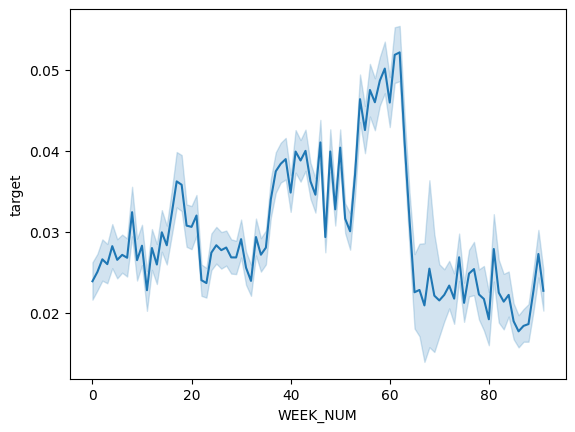

In [ ]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

### Training

LightGBM Model

In [ ]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

model = VotingModel(fitted_models)

### Prediction

In [ ]:
#LightGBM prediction
X_test = df_test.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")

y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

### Result


In [ ]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred

In [ ]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

Check null:  False


,score
case_id,
57543,0.013924
57549,0.050963
57551,0.003002
57552,0.009595
57569,0.109649


from matplotlib import pyplot as plt
_df_0['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
df_subm.to_csv("submission_LGB.csv")


# Training with 2 different Models

Run this section seprately with LightGB model section since I am using two different models here

###XGBoost Model

In [ ]:
#XGBoost
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 6,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbosity": 0,
    "random_state": 42,
    "tree_method": "gpu_hist",
    "enable_categorical": True , # Enable experimental categorical feature support
}

fitted_models = []

for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y, groups=weeks)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    fitted_models.append(model)
    print(f"Completed training fold {fold+1}/{cv.n_splits}")

# Function to compute average predictions from multiple models
def average_predict(models, X):
    preds = [model.predict_proba(X)[:, 1] for model in models]
    return np.mean(preds, axis=0)

# Example of creating a voting classifier from the fitted models (not needed if using average_predict)
model = VotingClassifier(estimators=[(f"model_{i}", m) for i, m in enumerate(fitted_models)], voting='soft')




[0]	validation_0-auc:0.72763
[100]	validation_0-auc:0.83338
[200]	validation_0-auc:0.84555
[300]	validation_0-auc:0.84926
[400]	validation_0-auc:0.85120
[500]	validation_0-auc:0.85216
[600]	validation_0-auc:0.85280
[700]	validation_0-auc:0.85328
[800]	validation_0-auc:0.85365
[900]	validation_0-auc:0.85395
[999]	validation_0-auc:0.85408
Completed training fold 1/5
[0]	validation_0-auc:0.72443
[100]	validation_0-auc:0.83608
[200]	validation_0-auc:0.84714
[300]	validation_0-auc:0.85028
[400]	validation_0-auc:0.85197
[500]	validation_0-auc:0.85310
[600]	validation_0-auc:0.85392
[700]	validation_0-auc:0.85450
[800]	validation_0-auc:0.85495
[900]	validation_0-auc:0.85525
[999]	validation_0-auc:0.85529
Completed training fold 2/5
[0]	validation_0-auc:0.73206
[100]	validation_0-auc:0.83931
[200]	validation_0-auc:0.85150
[300]	validation_0-auc:0.85526
[400]	validation_0-auc:0.85708
[500]	validation_0-auc:0.85808
[600]	validation_0-auc:0.85883
[700]	validation_0-auc:0.85938
[800]	validation_0-a

XGBoost Prediection and Results

In [ ]:
# Preparing X_test
X_test = df_test.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")

# Collecting predictions from each model
model_predictions = [model.predict_proba(X_test)[:, 1] for model in fitted_models]

# Calculating the average of the probabilities across all models
average_probabilities = np.mean(model_predictions, axis=0)

# Creating a pandas Series to store the final averaged probabilities
y_pred = pd.Series(average_probabilities, index=X_test.index)

print(y_pred.head())


case_id
57543    0.013924
57549    0.050963
57551    0.003002
57552    0.009595
57569    0.109649
dtype: float32


In [ ]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred


In [ ]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

Check null:  False


,score
case_id,
57543,0.013924
57549,0.050963
57551,0.003002
57552,0.009595
57569,0.109649


In [ ]:
df_subm.to_csv("submission_XGBoost.csv")

###CatBoost Model

In [ ]:
#CatBoost Model
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
groups = df_train["WEEK_NUM"]

# Identify categorical features
cat_features = [col for col in X.columns if X[col].dtype.name == 'category']

# Fill NaN values in categorical columns with a specific category 'missing'
for col in cat_features:
    X[col] = X[col].astype(str).fillna('missing')

# CatBoost parameters
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "loss_function": 'Logloss',
    "eval_metric": 'AUC',
    "random_seed": 42,
    "verbose": 100,
    "task_type": "GPU",
    "early_stopping_rounds": 50,  # More aggressive early stopping
    "border_count": 128  # Experiment this to balance accuracy vs speed further
}

# Model training setup
fitted_models = []
cv = GroupKFold(n_splits=5)

for idx_train, idx_valid in cv.split(X, y, groups=groups):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    # Use Pool to manage data and specify categorical features
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

    model = CatBoostClassifier(**params)
    model.fit(
        train_pool,
        eval_set=valid_pool,
        use_best_model=True
    )

    fitted_models.append(model)

# Combining models (simple averaging method for demonstration)
def average_predict(models, X):
    preds = [model.predict_proba(X)[:, 1] for model in models]
    return np.mean(preds, axis=0)


CatBoost Prediction and results

In [ ]:
# Fill NaN values in categorical columns with 'missing'
# Need fill NaN values here, since they are not automatically handled by CatBoost when making predictions
X_test[cat_features] = X_test[cat_features].astype(str).fillna('missing')

# Create a Pool object for the test set, ensuring consistency with training
test_pool = Pool(X_test, cat_features=cat_features)

# Now make predictions using the model trained earlier
y_pred = pd.Series(model.predict_proba(test_pool)[:, 1], index=X_test.index)

print(y_pred.head())

In [ ]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred

In [ ]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

In [ ]:
df_subm.to_csv("submission_CatBoost.csv")